In [1]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from scipy.signal import welch

In [2]:
#read in data file and skip to data
file=open("/Users/Roslyn/Desktop/run-XXXII", "r")

In [3]:
with file as f:
    lines_after_6 = f.readlines()[7:]

In [4]:
#extract first two coloumns and convert to float
col1=[]
for x in lines_after_6:
    col1.append(float(x.split()[0]))
        
col2=[]
for x in lines_after_6:
    col2.append(float(x.split()[1]))
    
#combine real and imaginary parts to give list of complex data outputs
data=np.vectorize(complex)(col1, col2)

In [5]:
#enter constants
f_mode1 = 4.993017E6
f_mode2 = 5.505658500E+6 #- 2.8
kappa_1 = 0.000576417
kappa_2 = 0.000619449
Q1 = 4.4E7
Q2 = 4.84E7
dt=0.01
fs=100

w_mode1= 2*np.pi*f_mode1
w_mode2= 2*np.pi*f_mode2
tau1=Q1/w_mode1
tau2=Q2/w_mode2

h0=0.0005
trap=0.848

Zsquid= 1.2e6

In [6]:
data1=data[:10000000]

In [7]:
print(len(data))

24089000


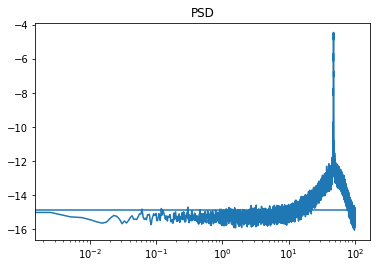

In [8]:
#PSD using Welch method 
f_1, S_1 = welch(
        (data1)-np.mean(data1), fs=fs, nperseg=(len(data1)/256),
         return_onesided=False, detrend=None, scaling='density', window='hanning')

#to plot log log have shifted frequency axis to positive 
plt.plot(f_1+abs(np.min(f_1)), 10*np.log10(S_1))
plt.title('PSD')
plt.xscale('log')


In [9]:
#SPECTRAL DISPLACEMENT DENSITY Su
#eq (8) GW Summary

#omega frequency axis, add mode freq 1 and convert from Hz to rad/s, and create squared axis 
w_1= [(x+f_mode1)*(2*np.pi) for x in f_1]
w_1sq= [x**2 for x in w_1]

#multiply 1/omega^2 list and Sv 
product1= [(1/a) * b for a, b in zip(w_1sq, S_1)]
 
#put into equation for Su(omega)
#10^-6 squared is a conversion from micro V to V
constants1 = (1/kappa_1**2)*(1/(Zsquid**2)*(10**(-6))**2)
Su1 = [x*(constants1) for x in product1]

Text(0.5, 1.0, 'Spectral Displacement Density')

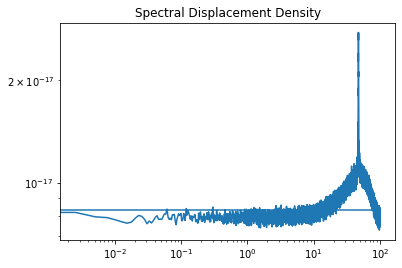

In [10]:
plt.plot(f_1+abs(np.min(f_1)), np.sqrt(Su1))
plt.xscale('log')
plt.yscale('log')
plt.title('Spectral Displacement Density')

In [11]:
#transfer function (equation 6 GW Summary)
def trans1(w):
    return np.absolute(((-w)**2*h0*trap/2)/((w*1j)**2+(w*1j)/tau1+w_mode1**2))

In [12]:
H_1=np.array(list(map(trans1,2*np.pi*(f_1+f_mode1))))

Text(0.5, 1.0, 'Transfer Function')

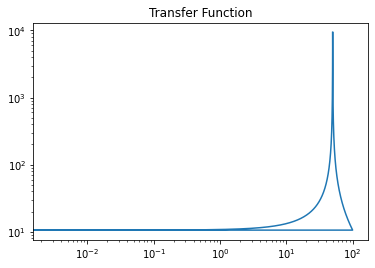

In [13]:
plt.plot(f_1+abs(np.min(f_1)), H_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Transfer Function')

Text(0.5, 1.0, 'Strain Sensitivity ')

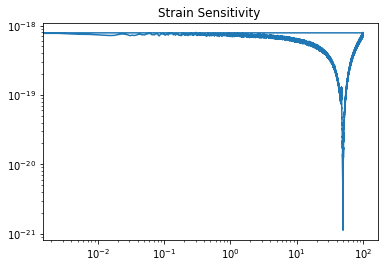

In [14]:
h_1=np.sqrt(Su1)/H_1

plt.plot(f_1+abs(np.min(f_1)), h_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Strain Sensitivity ')

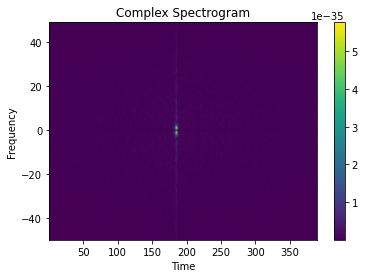

In [15]:
#complex data spectrogram
f, t, Sxx = signal.spectrogram(Su1-np.mean(Su1), 100, nperseg=100, return_onesided=False, mode='complex')
plt.pcolormesh(t, fftshift(f), fftshift(abs(Sxx)), shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Complex Spectrogram')
plt.show()

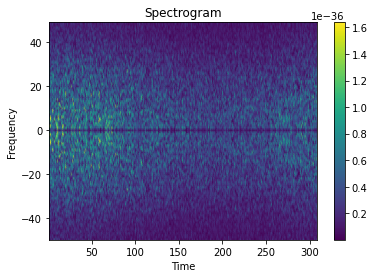

In [16]:
#extract section without power spike 
SxxA=np.array(Sxx)
SxxC= SxxA[0:100,0:350]

difft=np.delete(t[:351],0)

plt.pcolormesh(difft, fftshift(f), fftshift(abs(SxxC), axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Spectrogram')
plt.show()

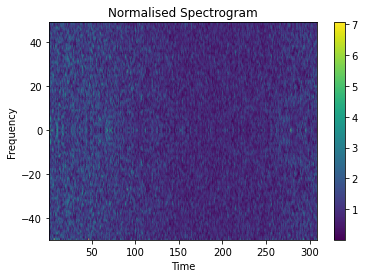

In [17]:
#FIND THRESHOLD NOISE AMPLITUDE AT FREQUENCY AWAY FROM RESONANT MODE 

#normalise data spectrogram 
absnormSxx=[]

for i in range(0,len(SxxC)):
    absnormSxx.append(abs((SxxC[i]/np.median(abs(SxxC[i])))))
    
plt.pcolormesh(difft, fftshift(f), fftshift(absnormSxx, axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Normalised Spectrogram')
plt.show()

In [18]:
#differencing for data spectrogram (D for data)

timecolsD=np.transpose(absnormSxx)

absdiffD=[]
slice1=[]

for j in range(0,len(absnormSxx)):
    slice1.clear()
    for i in range(0,(len(absnormSxx[0])-1)):
        slice1.append(abs(timecolsD[i+1][j]-timecolsD[i][j]))
    absdiffD.append(slice1[:])
    
#print(len(absdiffD))
#print(len(absdiffD[0]))

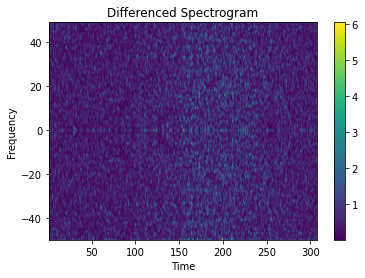

In [19]:
difftD=np.delete(t[:350],0)

plt.pcolormesh(difftD, fftshift(f), np.array(fftshift(absdiffD)), shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Differenced Spectrogram')
plt.show()

In [20]:
#select area away from res mode and find max amplitude (around 25-40Hz)

#this corresponds to frequency index approx 26-41
#print(np.shape(absdiffD))
#print(f)
absdiffDA=np.array(absdiffD)

noiserows=absdiffDA[26:41,:].copy()
print(np.shape(noiserows))

threshold=np.amax(noiserows)
print(threshold)

(15, 349)
3.5639293463149495


In [21]:
#create loop which essentially completes transient difference stest for 100 delta functions 
#at each of a range of h amplitudes to count if they are above threshold 

In [22]:
#(range and arange don't work well with non integer values)
h=np.linspace(1e-22,1e-21,10)
#print(len(h))
#print(h)

In [23]:
#create simulated transient for each h amplitude and resample to match dimension of spec to add
Su_sim=[]
slice2=[]

for i in range(0,len(h)):
    slice2.clear()
    for j in range(0,len(H_1)):
        slice2.append((h[i]*abs(H_1[j]))**2)
    Su_sim.append(signal.resample(slice2[:],len(f)))
    #Su_sim.append(slice2[:])
        
print(np.shape(Su_sim))
#print(len(Su_sim))
#print(len(Su_sim[0]))
#print(Su_sim)

(10, 100)


In [24]:
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[0])
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[1])
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[2])
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[3])
#plt.xscale('log')
#plt.yscale('log')
#plt.title('Transient Sim Spectral Displacement Density')

#transient shape before resampling looks to be correct 

In [25]:
import random

In [26]:
count=0
allcounts=[]

for y in range(0,len(h)):
    for x in range(0,100):
        randomcol=random.randint(0,(len(SxxC[0])-1))
        #print(randomcol)
        SxxC[:,randomcol]= [a+b for a,b in zip(SxxC[:,randomcol],Su_sim[y])]
    
        absnormSxxsim=[]

        for k in range(0,len(SxxC)):
            absnormSxxsim.append(abs((SxxC[k]/np.median(abs(SxxC[k])))))
    
        #print(absnormSxxsim[0][0])
    
        timecols=np.transpose(absnormSxxsim)
        absdiff=[]
        slice3=[]

        for j in range(0,len(absnormSxxsim)):
            slice3.clear()
            for i in range(0,(len(absnormSxxsim[0])-1)):
                slice3.append(abs(timecols[i+1][j]-timecols[i][j]))
            absdiff.append(slice3[:])
    
        #print(absdiff[0][0])
    
        maxamp=np.amax(absdiff)
        print(maxamp)
    
        if maxamp > threshold:
            count+=1
    
        SxxC[:,randomcol]= [a-b for a,b in zip(SxxC[:,randomcol],Su_sim[y])]

    allcounts.append(count)
    count=0


#print(count)
print(allcounts)
    

    
   

6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.065536674791294
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.0511280768972915
6.05112807689

33.01647088428092
36.123645969161885
34.232044046944985
35.18113169561654
34.12943377582303
34.679930830739075
34.57536567225968
33.23675559968509
33.43315175904366
34.65616202435205
34.60207638363624
31.820558394745515
36.64162960938801
34.041124158766
32.81194050057267
33.73581054488444
36.985244463290776
33.646612540287
35.33810781771183
34.09352917896051
32.308583823334715
34.51796944189559
32.925471591687
34.64791961791616
31.195153166480374
33.65377190280664
28.772866047500063
32.54112198973965
35.632944121725984
35.159828395575715
35.049095473503456
36.985244463290776
35.8624889501903
29.54103514162916
32.64991717074608
34.04532950846778
36.57529050735132
33.645140645262735
33.61125420731408
34.79299297737869
34.14904511027864
34.60207638363624
33.013296766158916
34.18066601382485
36.5032120874205
33.43315175904366
34.11365560360289
35.05065043913095
32.20965657746077
33.25610874799353
33.46858882669047
32.9980598352048
35.09820900778811
33.43315175904366
36.593719844687804
37.0

111.53114563041649
109.95862149364775
113.20029738399437
111.45086008475347
111.7783488646838
112.93996673204146
114.46295806510479
112.16032239143283
112.20637565884167
137.97690530729375
139.44259698782707
138.4263144197318
139.90395414929543
137.20868592249224
139.07049756456573
139.44253964485827
137.96332770013854
137.42259544901427
140.76287788268397
138.37546005431585
138.8835648681412
136.6164091497405
138.76070005835334
137.9288649946795
141.6748873141158
136.78439872009312
139.30993684765977
136.92183856702223
138.6607489011657
138.18259308230986
139.66606983182885
138.19606777764963
138.6997056493474
137.5611624838665
138.26919129550456
140.89324747802704
140.15364623058227
141.53045018621805
138.17003945477805
141.55792840024677
138.94521748137674
138.11215035882864
137.97690530729375
137.62425700439792
137.7470139389233
139.90395414929543
137.06997204305986
138.08775820451757
139.66606983182885
138.5083804053983
141.65396328370215
139.45469978342587
139.1224633202537
137.9

Text(0, 0.5, 'Fraction of Events above threshold')

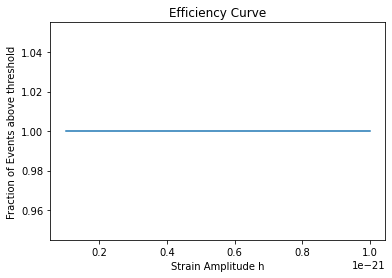

In [27]:
fraccounts=[x/100 for x in allcounts]

plt.plot(h,fraccounts)
plt.title('Efficiency Curve')
plt.xlabel('Strain Amplitude h')
plt.ylabel('Fraction of Events above threshold')
#plt.ylim(0,1)

In [28]:
#plt.pcolormesh(difft, fftshift(f), fftshift(abs(SxxC), axes=0), shading='gouraud')
#plt.colorbar()
#plt.xlim(0,350)
#plt.ylabel('Frequency')
#plt.xlabel('Time')
#plt.title('Sim Spectrogram')
#plt.show()

#looks like transient isnt being added

In [29]:
#plt.pcolormesh(difft, fftshift(f), fftshift((absnormSxxsim), axes=0), shading='gouraud')
#plt.colorbar()
#plt.xlim(0,350)
#plt.ylabel('Frequency')
#plt.xlabel('Time')
#plt.title('Norm Spectrogram')
#plt.show()